# Computing product ease of assembly with NLP
In this notebook we'll be finding the best word embedding for the job:
1. Reading in some labeled data
2. Preprocess the data for each intended model
3. Splitting the data into test/train sets   
4. Embed a few models on the train set (BoW, word2vec, doc2vec, I'll add BERT later)
5. Logistic regression on the train set (test data)
6. Evaluate output (confusion matrix and other checks)
7. Use VADER to get an assembly rating
8. Evaluate output 
9. Label ALL review sentences
10. Get subtopics with LDA

In [1]:
# Import cell
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer 
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import pickle
import csv
import random

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
# Products that I've scraped data for
product_set = ( 'office+chair',
                'office+desk',
                'kitchen+table',
                'living+room+couch',
                'end+table',
                'bed+frame',
                'crib',
                'bookcase',
                'coffee+table')

## 1. Read in the labeled data


In [3]:
# The directory for my data
data_directory = "../data/"

In [4]:
# Let's import our labeled sentence dataset
labeled_xls = data_directory + "sentence_rating.xlsx"
labeled_sentences = pd.read_excel(labeled_xls, sheet_name='Sheet1')
labeled_sentences.dropna(subset = ["assembly"], inplace=True)

assembly_sentences = sum(labeled_sentences['assembly'].tolist())
total_sentences = len(labeled_sentences['assembly'])
non_assembly_sentences = total_sentences - assembly_sentences
default_accuracy = float(non_assembly_sentences) / len(labeled_sentences['assembly'])

print("Number of assembly-related sentences:", assembly_sentences)
print("Default accuracy:", round(default_accuracy, 2))

display(labeled_sentences)

Number of assembly-related sentences: 162.0
Default accuracy: 0.84


,Sentence,assembly,rate_ease,quality,rate_quality
0,Disappointed.,0.0,NaN,0.0,NaN
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0
...,...,...,...,...,...
994,"I am 6'1"" 215 pounds.",0.0,NaN,NaN,NaN
995,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN
996,"All in all, it's made my work day a lot more p...",0.0,NaN,NaN,NaN
997,Great price and VERY easy to put together.,1.0,5.0,NaN,NaN


In [5]:
# We are going to undersample the data to balance out the labels
import random
random.seed(42)

# How much do we want to balance the data (1.0 is a completely balanced data set)
under_sample_factor = 2.0

assembly_indices = []
regular_indices = []

# Get a list of all the assembly sentences
for i in range(0, len(labeled_sentences['assembly'])):
    if labeled_sentences['assembly'].iloc[i] == 1.0:
        assembly_indices.append(i)
    # Maybe this biases towards shorter sentences?
    else:
        regular_indices.append(i)
        
# Get a random sample of regular sentences
assembly_indices = np.sort(assembly_indices)
# regular_balanced = np.sort(random.sample(regular_indices, int(assembly_sentences)))
regular_balanced = np.sort(random.sample(regular_indices, int(assembly_sentences * under_sample_factor)))

# Check to make sure all looks good
print(len(assembly_indices))
print(len(regular_balanced))
# print(assembly_indices)
# print(regular_balanced)

# Now let's make a new dataframe from these indices
df_list = []
for i in assembly_indices:
    df_list.append([])
    df_list[-1].append(labeled_sentences['Sentence'].iloc[i])
    df_list[-1].append(labeled_sentences['assembly'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_ease'].iloc[i])
    df_list[-1].append(labeled_sentences['quality'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_quality'].iloc[i])
    
for i in regular_balanced:
    df_list.append([])
    df_list[-1].append(labeled_sentences['Sentence'].iloc[i])
    df_list[-1].append(labeled_sentences['assembly'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_ease'].iloc[i])
    df_list[-1].append(labeled_sentences['quality'].iloc[i])
    df_list[-1].append(labeled_sentences['rate_quality'].iloc[i])
    
# Convert this to a dataframe
under_sampled = pd.DataFrame(df_list, columns =['sentence', 'assembly', 'rate_ease', 'quality', 'rate_quality']) 
display(under_sampled)

162
324


,sentence,assembly,rate_ease,quality,rate_quality
0,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN
1,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN
2,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0
3,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN
4,This was very simple and the instructions were...,1.0,5.0,0.0,NaN
...,...,...,...,...,...
481,"Careful when assembling, came with a tiny nick...",0.0,NaN,NaN,NaN
482,The braket that goes on the bottom to hold the...,0.0,NaN,NaN,NaN
483,I may even have to buy another 1 or 2 to put u...,0.0,NaN,NaN,NaN
484,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN


## 2. Preprocess the text for each embedding type

## BoW: 
lowercase, no tags, no special characters, no punctuation, no extra whitespace, no stopwords

In [6]:
import gensim.parsing.preprocessing as gpp

# Process the data for BoW
sample = under_sampled["sentence"].iloc[2]
print("Bag of words cleaning:")
print("Input:", sample)

# What do we want to remove from our sentences?
bow_filter = [lambda x: x.lower(),
              gpp.strip_tags,
              gpp.split_alphanum,
              gpp.strip_non_alphanum,
              gpp.strip_punctuation,
              gpp.strip_multiple_whitespaces,
              gpp.strip_short,
              gpp.stem_text,
              gpp.remove_stopwords]

def bow_clean(sentence, in_filter):
    out = gpp.preprocess_string(sentence, in_filter)
    reform = ""
    for i in out:
        reform += i
        reform += " "
    return reform
    

out = bow_clean(sample, bow_filter)
print("Output:", out)

# Apply the cleaning functions
under_sampled['bow'] = under_sampled['sentence'].apply(lambda x: bow_clean(x, bow_filter))
display(under_sampled)

Bag of words cleaning:
Input: Super comfortable and easy to put together (Took about 10minutes).
Output: super comfort easi togeth took minut 


,sentence,assembly,rate_ease,quality,rate_quality,bow
0,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,wa easi togeth clear instruct particularli lik...
1,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN,deliveri wa fast assembl wa easi screw leg
2,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0,super comfort easi togeth took minut
3,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN,took coupl hour assembl chair
4,This was very simple and the instructions were...,1.0,5.0,0.0,NaN,thi wa veri simpl instruct easi understand
...,...,...,...,...,...,...
481,"Careful when assembling, came with a tiny nick...",0.0,NaN,NaN,NaN,care assembl came tini nick splinter wood real...
482,The braket that goes on the bottom to hold the...,0.0,NaN,NaN,NaN,braket goe hold desk togetehr doesnt fit long
483,I may even have to buy another 1 or 2 to put u...,0.0,NaN,NaN,NaN,mai bui anoth desk storag
484,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN,realli great tabl sturdi veri afford price


## word2vec:
BoW + tokenized

In [7]:
# I'm going to use gensim for this
sample = under_sampled["sentence"].iloc[2]
print("word2vec cleaning:")
print("")
print("Input", sample)
print("")

# What do we want to remove from our sentences?
w2v_filter = [lambda x: x.lower(),
              gpp.strip_tags,
              gpp.split_alphanum,
              gpp.strip_non_alphanum,
              gpp.strip_punctuation,
              gpp.strip_multiple_whitespaces,
              gpp.stem_text,
              gpp.strip_short,
              gpp.remove_stopwords]

out = gpp.preprocess_string(sample, w2v_filter)
print("Output:", out)
print("")

# Apply the cleaning functions
under_sampled['w2v'] = under_sampled['sentence'].apply(lambda x: gpp.preprocess_string(x, w2v_filter))
display(under_sampled)

word2vec cleaning:

Input Super comfortable and easy to put together (Took about 10minutes).

Output: ['super', 'comfort', 'easi', 'togeth', 'took', 'minut']



,sentence,assembly,rate_ease,quality,rate_quality,bow,w2v
0,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,wa easi togeth clear instruct particularli lik...,"[easi, togeth, clear, instruct, particularli, ..."
1,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN,deliveri wa fast assembl wa easi screw leg,"[deliveri, fast, assembl, easi, screw, leg]"
2,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0,super comfort easi togeth took minut,"[super, comfort, easi, togeth, took, minut]"
3,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN,took coupl hour assembl chair,"[took, coupl, hour, assembl, chair]"
4,This was very simple and the instructions were...,1.0,5.0,0.0,NaN,thi wa veri simpl instruct easi understand,"[thi, veri, simpl, instruct, easi, understand]"
...,...,...,...,...,...,...,...
481,"Careful when assembling, came with a tiny nick...",0.0,NaN,NaN,NaN,care assembl came tini nick splinter wood real...,"[care, assembl, came, tini, nick, splinter, wo..."
482,The braket that goes on the bottom to hold the...,0.0,NaN,NaN,NaN,braket goe hold desk togetehr doesnt fit long,"[braket, goe, hold, desk, togetehr, doesnt, fi..."
483,I may even have to buy another 1 or 2 to put u...,0.0,NaN,NaN,NaN,mai bui anoth desk storag,"[mai, bui, anoth, desk, storag]"
484,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN,realli great tabl sturdi veri afford price,"[realli, great, tabl, sturdi, veri, afford, pr..."


## 3. Split the data

In [8]:
# We're splitting 70/30 for now
split = 0.2
seed = 42

# Perform the same split for each embedding type
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(under_sampled['bow'], 
                                                                    under_sampled['assembly'], 
                                                                    test_size=split, 
                                                                    random_state=seed)
# And for w2v
x_train_w2v, x_test_w2v, y_train_w2v, y_test_w2v = train_test_split(under_sampled['w2v'], 
                                                                    under_sampled['assembly'], 
                                                                    test_size=split, 
                                                                    random_state=seed)

# Let's hold everything in one data frame
train_frame = {'x_bow': x_train_bow, 'y_bow': y_train_bow, 'x_w2v': x_train_w2v, 'y_w2v': y_train_w2v}
train_data = pd.DataFrame(train_frame)

# And for test
test_frame = {'x_bow': x_test_bow, 'y_bow': y_test_bow, 'x_w2v': x_test_w2v, 'y_w2v': y_test_w2v}
test_data = pd.DataFrame(test_frame)

# Take a peak to make sure all is well
display(train_data)

,x_bow,y_bow,x_w2v,y_w2v
132,chair easi assembl ha good height adjust goe l...,1.0,"[chair, easi, assembl, good, height, adjust, g...",1.0
25,pro easi assembl sturdi look nice offer adequ ...,1.0,"[pro, easi, assembl, sturdi, look, nice, offer...",1.0
222,overal extrem happi purchas recommend thi tabl...,0.0,"[overal, extrem, happi, purchas, recommend, th...",0.0
316,husband work home multipl occas ha tri steal,0.0,"[husband, work, home, multipl, occas, tri, steal]",0.0
294,feel sturdi,0.0,"[feel, sturdi]",0.0
...,...,...,...,...
106,everyth wa includ direct clear,1.0,"[everyth, includ, direct, clear]",1.0
270,pai,0.0,[pai],0.0
348,love qualiti look,0.0,"[love, qualiti, look]",0.0
435,overal thi chair built veri veri support desk ...,0.0,"[overal, thi, chair, built, veri, veri, suppor...",0.0


## 4. Embed the models

## BoW

In [9]:
# We'll start with BoW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instantiate the count vectorizer 
# -n-grams of length 1 and 2
# -ignore words that are in more than 50% of sentences
# -ignore words that are in fewer than 0.5% of sentences
# cv = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=0.005)
cv = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=0.005)

# Make the x train a list
bow_x_train_list = train_frame['x_bow'].tolist()

# Feed our sentences to the count vectorizer
count_data = cv.fit_transform(bow_x_train_list)

# Print the number of words being used
print(len(cv.get_feature_names()))
# A list of the words
bow_words = cv.get_feature_names()
# A dataframe of the train data
cv_df = pd.DataFrame(count_data.toarray(), columns = cv.get_feature_names())
display(cv_df)

464


,100,abl,abl assembl,abl togeth,absolut,actual,adjust,afford,air,alreadi,...,work,work bench,work dai,work home,work space,worth,worth monei,wrap,wrap bubbl,year
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Let's get the counts of these words for the test set as well
bow_test_vectors = []
for sentence in test_frame['x_bow']:
    #sentence_tokens = nltk.word_tokenize(sentence)
    sentence_tokens = []
    gs_tokenizer = gensim.utils.tokenize(sentence)
    for iii in gs_tokenizer:
        sentence_tokens.append(iii)
    sent_vec = []
    for token in bow_words:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    bow_test_vectors.append(sent_vec)

## w2v

In [11]:
# The parameters for the w2v model
# size      : should be low (~100) if you don't have much data and large (~1000) if you have a lot of data
# window    : is how many words to search for a keyword
# min_count : the model will ignore words which do not appear at least this frequently 
trained_w2v = gensim.models.Word2Vec(train_frame['x_w2v'], min_count=2, window=5, size=100)

# Show the vocab
trained_w2v.wv.vocab

# Just a few things to show what we can do with w2v
target = 'assembl'
trained_w2v.wv.most_similar(positive=target)

[('nice', 0.3735298812389374),
 ('veri', 0.30402815341949463),
 ('neatli', 0.2823355793952942),
 ('son', 0.2818726897239685),
 ('sit', 0.28132787346839905),
 ('feel', 0.26856207847595215),
 ('thi', 0.257124125957489),
 ('min', 0.24767300486564636),
 ('dimens', 0.24474728107452393),
 ('bed', 0.24195410311222076)]

In [12]:
# def word_averaging(w2v, sentence):
#     # remove out-of-vocabulary words
#     words = [word for word in sentence if word in w2v.vocab]
#     if len(words) >= 1:
#         return np.mean(w2v[words], axis=0)
#     else:
#         return []
# 
# sample = train_data['x_w2v'].iloc[0]
# print(sample)
# mean = word_averaging(trained_w2v.wv, sample)
# print(mean)

In [13]:
# w2v comes with an additional step: averaging the word vectors over sentences
def word_averaging(wv, sentence):
    all_words, mean = set(), []
    # Loop through each word in the sentence
    for word in sentence:
        if word in wv.vocab:
            # This works for data-trained
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    # Check if mean is empty
    if not mean:
        return [0. for i in range(wv.vector_size)]
        
    # Creat a list that sums the vectors
    sum_vec = [0. for i in range(len(mean[0]))]
    for i in range(0, len(mean)):
        for j in range(0, len(mean[0])):
            sum_vec[j] += mean[i][j]
            
    # Divide by the number of vectors that were added
    mean_vec = [ i / float(len(mean)) for i in sum_vec]
            
    # Get the magnitude
    mag = 0.
    for i in sum_vec:
        mag += (i**2.)
        
    # Compute the unit vector
    mean_unit_vec = [ i / float(mag**0.5) for i in mean_vec ]

    return mean_unit_vec

In [14]:
# Compute the average word vector for each sentence
train_sentence_means = []
for i in range(0, len(train_frame['x_w2v'])):
    sentence_mean = word_averaging(trained_w2v.wv, train_frame['x_w2v'].iloc[i])
    train_sentence_means.append(sentence_mean)
    # Make sure the vectors are the correct length
    #print(len(train_sentence_means[-1]))
    
test_sentence_means = []
for i in range(0, len(test_frame['x_w2v'])):
    sentence_mean = word_averaging(trained_w2v.wv, test_frame['x_w2v'].iloc[i])
    test_sentence_means.append(sentence_mean)
    # Make sure the vectors are the correct length
    #print(len(test_sentence_means[-1]))


## 5. Regress the models

## BoW

In [15]:
# We'll use logistic regression
bow_regression = LogisticRegression(n_jobs=1)
# Get count vector lists for each sentence
bow_x = cv_df.values.tolist()
bow_y = train_frame['y_bow'].tolist()
# This give our logistic regression fit to the training data
bow_regression = bow_regression.fit(bow_x, bow_y)

# We can see how the test data matches up by predicting y from the x vectors
bow_predict = bow_regression.predict(bow_test_vectors)
print(sum(bow_predict))
real_y = test_frame['y_bow'].tolist()
print(sum(real_y))

# Number correct and incorrect
correct = 0
incorrect = 0
for i in range(0, len(bow_predict)):
    if bow_predict[i] == real_y[i]:
        correct += 1
    else:
        incorrect += 1
percent_correct = float(correct) / len(real_y) * 100.
        
print(f"Model accuracy: {round(percent_correct, 1)}%")

32.0
35.0
Model accuracy: 92.9%


In [16]:
# Compute the F1 score
bow_f1 = f1_score(real_y, bow_predict)
print(round(bow_f1, 2))

0.9


## w2v

In [17]:
# We'll use logistic regression
w2v_regression = LogisticRegression(n_jobs=1)
# Get count vector lists for each sentence
w2v_x = train_sentence_means
w2v_y = train_frame['y_w2v'].tolist()
# This give our logistic regression fit to the training data
w2v_regression = w2v_regression.fit(w2v_x, w2v_y)

# We can see how the test data matches up by predicting y from the x vectors
w2v_predict = w2v_regression.predict(test_sentence_means)
print(sum(w2v_predict))
real_y = test_frame['y_w2v'].tolist()
print(sum(real_y))

# Number correct and incorrect
correct = 0
incorrect = 0
for i in range(0, len(w2v_predict)):
    if w2v_predict[i] == real_y[i]:
        correct += 1
    else:
        incorrect += 1
percent_correct = float(correct) / len(real_y) * 100.
        
print(f"Model accuracy: {round(percent_correct, 1)}%")

5.0
35.0
Model accuracy: 69.4%


## 6. Evaluate

## BoW

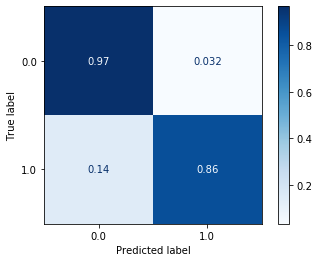

In [18]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_bow = confusion_matrix(real_y, bow_predict)
disp = plot_confusion_matrix(bow_regression, bow_test_vectors, real_y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()


## w2v

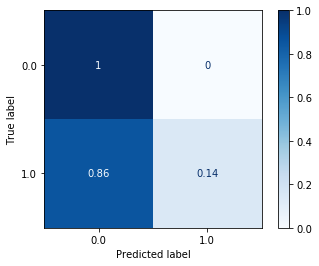

In [19]:
disp = plot_confusion_matrix(w2v_regression, test_sentence_means, real_y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()

## 7. Analyze sentiment with VADER

In [20]:
# Okay, now we layer a sentiment analysis on this
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_sentiment(sentence):
    '''Assign sentiment to any give sentence using VADER'''
    # Instantiate the sentiment analyzer
    sentiment = SentimentIntensityAnalyzer()
    # Get the sentiment dictionary for my sentence
    sentiment_dict = sentiment.polarity_scores(sentence) 
    # Output the compound sentiment (between [-1, 1])
    out = sentiment_dict['compound']
    # Renormalize this to be [1, 5]
    stars = (out * 2.) + 3.
    return round(stars, 0)

In [21]:
# Let's get a column of sentiment
labeled_sentences['vader_rating'] = labeled_sentences['Sentence'].apply(get_sentiment)

In [22]:
display(labeled_sentences)

,Sentence,assembly,rate_ease,quality,rate_quality,vader_rating
0,Disappointed.,0.0,NaN,0.0,NaN,2.0
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN,3.0
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,5.0
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN,4.0
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0,3.0
...,...,...,...,...,...,...
994,"I am 6'1"" 215 pounds.",0.0,NaN,NaN,NaN,3.0
995,Really great table sturdy and at a very afford...,0.0,NaN,NaN,NaN,4.0
996,"All in all, it's made my work day a lot more p...",0.0,NaN,NaN,NaN,5.0
997,Great price and VERY easy to put together.,1.0,5.0,NaN,NaN,5.0


## 8. Evaluate VADER performance

In [23]:
# We'll drop all rows that don't have an ease of assembly rating
only_labeled = labeled_sentences.dropna(subset = ["rate_ease"])
only_labeled['rate_diff'] = only_labeled['rate_ease'] - only_labeled['vader_rating'] 
display(only_labeled)

,Sentence,assembly,rate_ease,quality,rate_quality,vader_rating,rate_diff
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,5.0,0.0
6,Delivery was fast and assembly was easy...just...,1.0,5.0,0.0,NaN,3.0,2.0
17,Super comfortable and easy to put together (To...,1.0,5.0,1.0,5.0,5.0,0.0
28,It took a couple of hours to assemble two chairs.,1.0,3.0,0.0,NaN,3.0,0.0
30,This was very simple and the instructions were...,1.0,5.0,0.0,NaN,4.0,1.0
...,...,...,...,...,...,...,...
987,My boyfriend said it will be relative easy to ...,1.0,3.0,NaN,NaN,4.0,-1.0
989,"Great chair, easy assembly.",1.0,5.0,NaN,NaN,5.0,0.0
993,I would not have ran into this issue if it cam...,1.0,1.0,NaN,NaN,3.0,-2.0
997,Great price and VERY easy to put together.,1.0,5.0,NaN,NaN,5.0,0.0


In [24]:
# Let's look at the differences in distribution here
labeled_rating = only_labeled['rate_ease'].tolist()
vader_rating = only_labeled['vader_rating'].tolist()

Text(0, 0.5, 'Number of ratings')

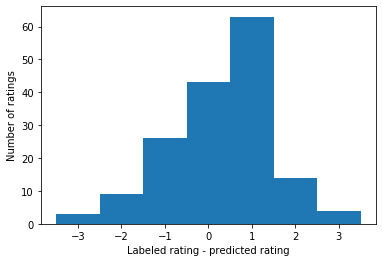

In [25]:
# Plot histogram of difference between "true" and predicted
bins = np.arange(-3,5,1)-0.5
ax = only_labeled['rate_diff'].plot.hist(bins=bins)
# ax.set_xlim(-3, 3)
ax.set_xlabel(r'Labeled rating - predicted rating')
ax.set_ylabel(r'Number of ratings')

## 9. Label sentences with BoW

In [26]:
# Load in the data
product_dfs = []
for i in product_set:
    this_df = pd.read_csv(data_directory + 'review_csvs/' + i + '_review_data.csv')
    this_df.insert(0, 'Type', i)
    product_dfs.append(this_df)
products = pd.concat(product_dfs)

# Add a column for product ID
product_list = []
product_review_count = []
product_id = -1
id_list = []
for i in range(len(products['product'])):
    # If the product isn't yet in the list...
    if products['product'].iloc[i] not in product_list:
        # Add it to the list of distinct products
        product_list.append(products['product'].iloc[i])
        # Add new counter for number of reviews
        product_review_count.append(1)
        # Increment the distinct product id number
        product_id += 1
        
    id_list.append(product_id)
    product_review_count[-1] += 1
    
# Add the product id to the dataframe
products.insert(0, 'id', id_list)

# Print the id and name of the product with the most reviews
most_reviews = max(product_review_count)
most_reviews_id = product_review_count.index(most_reviews)
most_reviews_name = product_list[most_reviews_id]
# print(f'{most_reviews_name} has the most product reviews: {most_reviews}')

# display(products)

In [27]:
# We have to break this data into sentences to train the model
all_sentences = []
sentence_id = []
products.dropna(subset = ["content"], inplace=True)
for i in range(0, len(products['content'])):
    current = tokenize.sent_tokenize(products['content'].iloc[i])
    for j in range(0, len(current)):
        all_sentences.append(current[j])
        sentence_id.append(i)
        
# Confirm that you've split up the sentences
# print(products['content'].iloc[0])
# print("")
# 
# for i in range(0, 5):
#     print(all_sentences[i])
    
# Make a sentences-only dataframe and drop the duplicates
all_sentences = list(dict.fromkeys(all_sentences))

In [28]:
# Let's make and clean a sentence dataframe
s = {'sentence':all_sentences}
sentence_df = pd.DataFrame(s)

# Remove any rows that don't have review data
sentence_df.dropna(subset = ["sentence"], inplace=True)

# Apply the cleaning functions
sentence_df['bow'] = sentence_df['sentence'].apply(lambda x: gpp.preprocess_string(x, bow_filter))
display(sentence_df)

,sentence,bow
0,The fabric/pleather on this chair has torn aft...,"[fabric, pleather, thi, chair, ha, torn, month..."
1,"It was super comfortable, relatively easy to a...","[wa, super, comfort, rel, easi, assembl, reall..."
2,I would like to return the product but can’t s...,"[like, return, product, ship, especi, pandem]"
3,I never write reviews but this purchase ended ...,"[write, review, thi, purchas, end, bummer]"
4,Give me my money back without a return Mr. Bez...,"[monei, return, bezo, send, new, chair]"
...,...,...
345369,I only have it 4 stars for sturdiness because ...,"[onli, star, sturdi, becaus, sit, edg, bit, ti..."
345370,Stay centered and your good.,"[stai, center, good]"
345371,The cushion it’s self is like a memory foam- s...,"[cushion, self, like, memori, foam, comfi]"
345372,My husband notice that right away.,"[husband, notic, right, awai]"


In [29]:
# Create a vector for each sentence
def get_sentence_vector(sentence):
    sentence_vector = []
    for token in bow_words:
        if token in sentence:
            sentence_vector.append(1)
        else:
            sentence_vector.append(0)
    return sentence_vector

# Get vectors of corpus
sentence_df['bow_vecs'] = sentence_df['bow'].apply(lambda x: get_sentence_vector(x))

In [30]:
# Predict output based on regression
all_x = sentence_df['bow_vecs'].tolist()
assemble = bow_regression.predict(all_x)
sentence_df['assemble'] = assemble
display(sentence_df)

,sentence,bow,bow_vecs,assemble
0,The fabric/pleather on this chair has torn aft...,"[fabric, pleather, thi, chair, ha, torn, month...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,"It was super comfortable, relatively easy to a...","[wa, super, comfort, rel, easi, assembl, reall...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,I would like to return the product but can’t s...,"[like, return, product, ship, especi, pandem]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,I never write reviews but this purchase ended ...,"[write, review, thi, purchas, end, bummer]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,Give me my money back without a return Mr. Bez...,"[monei, return, bezo, send, new, chair]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...,...,...
345369,I only have it 4 stars for sturdiness because ...,"[onli, star, sturdi, becaus, sit, edg, bit, ti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
345370,Stay centered and your good.,"[stai, center, good]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
345371,The cushion it’s self is like a memory foam- s...,"[cushion, self, like, memori, foam, comfi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
345372,My husband notice that right away.,"[husband, notic, right, awai]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


In [31]:
# A quick check to make sure the stastics of the ML-labeled data compare well with the labeled data
print( sum(sentence_df['assemble']) / len(sentence_df['assemble']))

0.13470614464319838


In [32]:
# Drop the non-assembly sentences
assembly_sentences = sentence_df[sentence_df.assemble != 0]
display(assembly_sentences)

,sentence,bow,bow_vecs,assemble
1,"It was super comfortable, relatively easy to a...","[wa, super, comfort, rel, easi, assembl, reall...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
7,I continued putting the chair together and fig...,"[continu, chair, togeth, figur, try, deal, zip...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
8,The chair itself was simple to assemble.,"[chair, wa, simpl, assembl]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
9,However it took a lot of finagling to get the ...,"[howev, took, lot, finagl, zipper, togeth, req...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
28,Be careful when installing the seat to armrest...,"[care, instal, seat, armrest, screw]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
...,...,...,...,...
345285,There is NO assembly.,[assembl],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
345286,Just took it out of the box and ready to go.,"[took, box, readi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
345313,"Modern style, easy to assemble and pretty steady!","[modern, style, easi, assembl, pretti, steadi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
345315,"However, our item arrived with without a screw...","[howev, item, arriv, screw, thread, tabl, scre...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0


## 10. Perform LDA on assembly sentences

In [ ]:
# Split the data set again
x_lda_train, x_lda_text, y_lda_train, y_lda_test = train_test_split(assembly_sentences[''], assembly_sentences[], test_size=split, random_state=seed)
